# Modeling

In [6]:
from data_loading import load_data
import configuration
from matplotlib import pyplot as plt

data = load_data()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1883 non-null   datetime64[ns]
 1   EMP     1883 non-null   float64       
 2   PE      1883 non-null   float64       
 3   CAPE    1883 non-null   float64       
 4   DY      1883 non-null   float64       
 5   Rho     1883 non-null   float64       
 6   MOV     1883 non-null   float64       
 7   IR      1883 non-null   float64       
 8   RR      1883 non-null   float64       
 9   Y02     1883 non-null   float64       
 10  Y10     1883 non-null   float64       
 11  STP     1883 non-null   float64       
 12  CF      1883 non-null   float64       
 13  MG      1883 non-null   float64       
 14  RV      1883 non-null   float64       
 15  ED      1883 non-null   float64       
 16  UN      1883 non-null   float64       
 17  GDP     1883 non-null   float64       
 18  M2      

In [8]:
import torch
from modeling.Predictor import Predictor
from data_loading import split_dataset, create_dataloaders
import copy
from modeling.Trainer import Trainer
from models.LSTM import LSTM
from models.MLP import MLP
from models.CNN import CNN

feature_selection = ['CF', 'Y10', 'MOV ']

train_data = data[feature_selection + ['Date', '_MKT']]

look_aheads = [1, 4, 52]
pred_length = 1
window_size = 52
is_indexed = [True, False]

num_features = len(feature_selection) + 1
results = []

for indexed in is_indexed:
    for look_ahead in look_aheads:
        model_cnn = CNN(window_size=window_size,
                        num_features=num_features,
                        output_size=1,
                        kernel_size=21,
                        num_conv=3,
                        padding=True,
                        channels=2,
                        hidden_size=100,
                        num_hidden_layers=2,
                        dropout=0.2
                        )

        model_lstm = LSTM(num_features=num_features,
                          output_size=1,
                          num_LSTM_layers=4,
                          num_hidden_layers=2,
                          hidden_size=200,
                          dropout=0.2)

        model_mlp = MLP(window_size=window_size,
                        num_features=num_features,
                        output_size=1,
                        num_hidden_layers=2,
                        hidden_size=200,
                        dropout=0.2)

        models = {'CNN': (model_cnn, 1e-4),
                  'LSTM': (model_lstm, 1e-1),
                  'MLP': (model_mlp, 1e-4)
                  }
    
        train_set, val_set, test_set = split_dataset(train_data,
                                                     window_size=window_size,
                                                     prediction_length=pred_length,
                                                     look_ahead=look_ahead,
                                                     scale_target=indexed,
                                                     fixed_feature_size=None,
                                                     is_indexed=indexed)

        train_loader, val_loader, test_loader = create_dataloaders(train_set, val_set, test_set,
                                                                   shuffle_train_loader=True,
                                                                   batch_size=200)

        for model_name, (model, lr) in models.items():
            trainer = Trainer(copy.deepcopy(model), epochs=100, learning_rate=lr, early_stopping=True)

            trained_model, loss = trainer.train(train_loader, val_loader, print_out=False, return_loss=True,
                                                return_all_networks=False)

            predictions, targets = Predictor(trained_model).predict(test_loader)

            mse = torch.nn.functional.mse_loss(torch.tensor(predictions), torch.tensor(targets)).item()
            mae = torch.nn.functional.l1_loss(torch.tensor(predictions), torch.tensor(targets)).item()

            results.append([indexed, look_ahead, model_name, mse, mae, predictions, targets])



In [9]:
def plot_prediction_indexed(preds, targets, title):
    x = range(len(targets))
    plt.figure(figsize=configuration.fig_size, dpi=configuration.dpi_display)
    plt.plot(x, targets, color='blue', label='Targets')
    plt.plot(x, preds, color='orange', label='Predictions')
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_prediction_returns(preds, targets, title, look_ahead):
    chart_values = [100 for i in range(look_ahead)]
    chart_preds = [100 for i in range(look_ahead)]

    for r in targets:
        chart_values.append(chart_values[-look_ahead] * (1 + r))

    for i, p in enumerate(preds):
        chart_preds.append(chart_values[i] * (1 + p))

    chart_preds = chart_preds[look_ahead:]
    chart_values = chart_values[look_ahead:]

    x = range(len(targets))
    plt.figure(figsize=configuration.fig_size, dpi=configuration.dpi_display)
    plt.plot(x, chart_values, color='blue', label='Targets')
    plt.plot(x, chart_preds, color='orange', label='Predictions')
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()


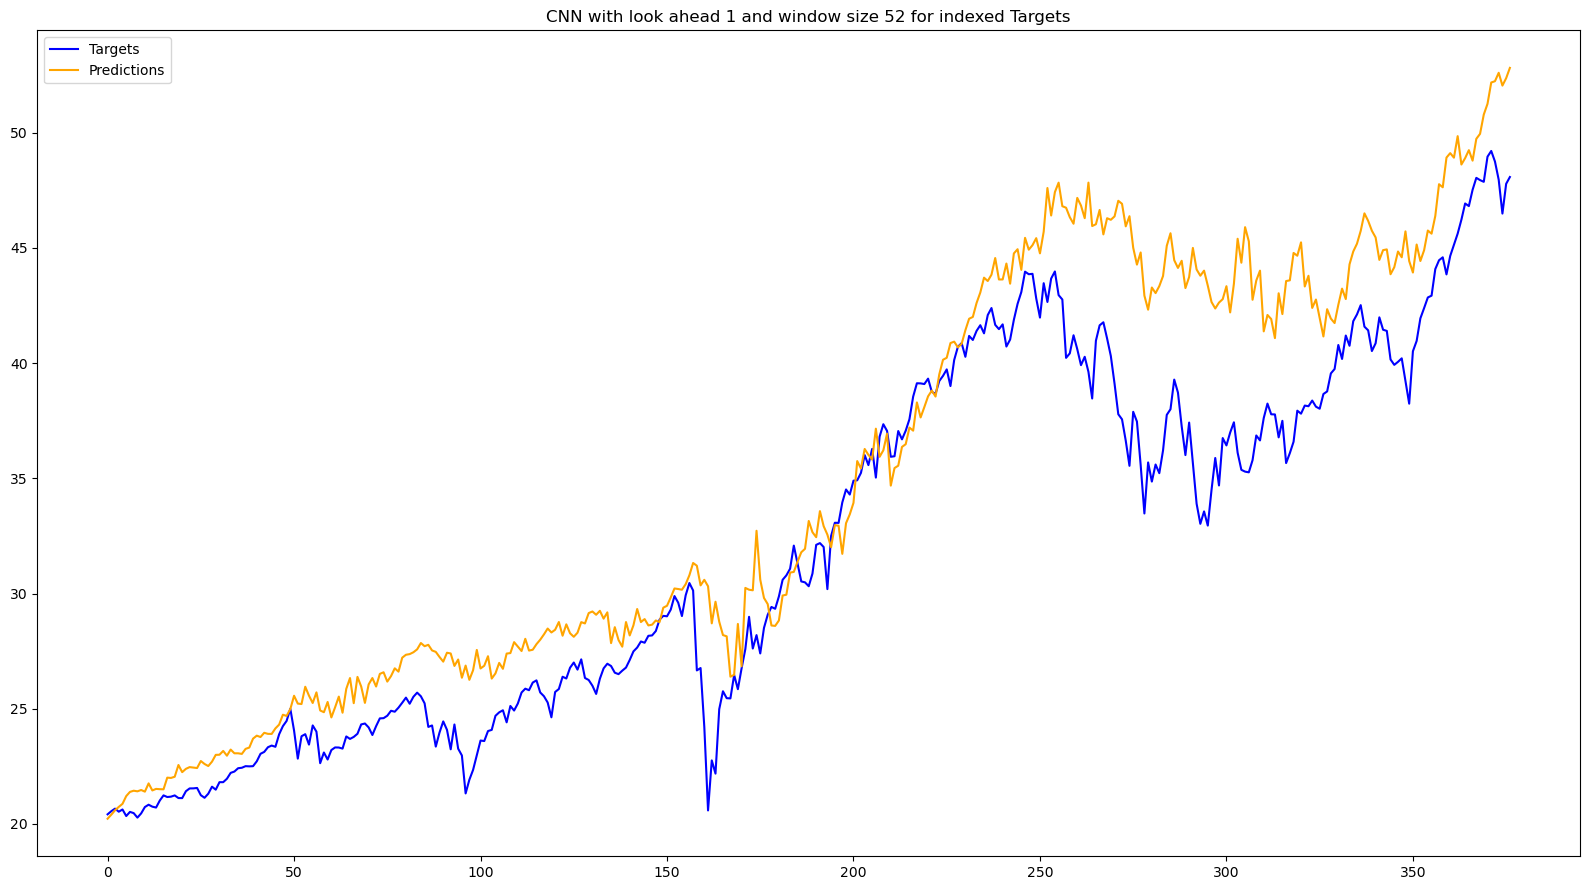

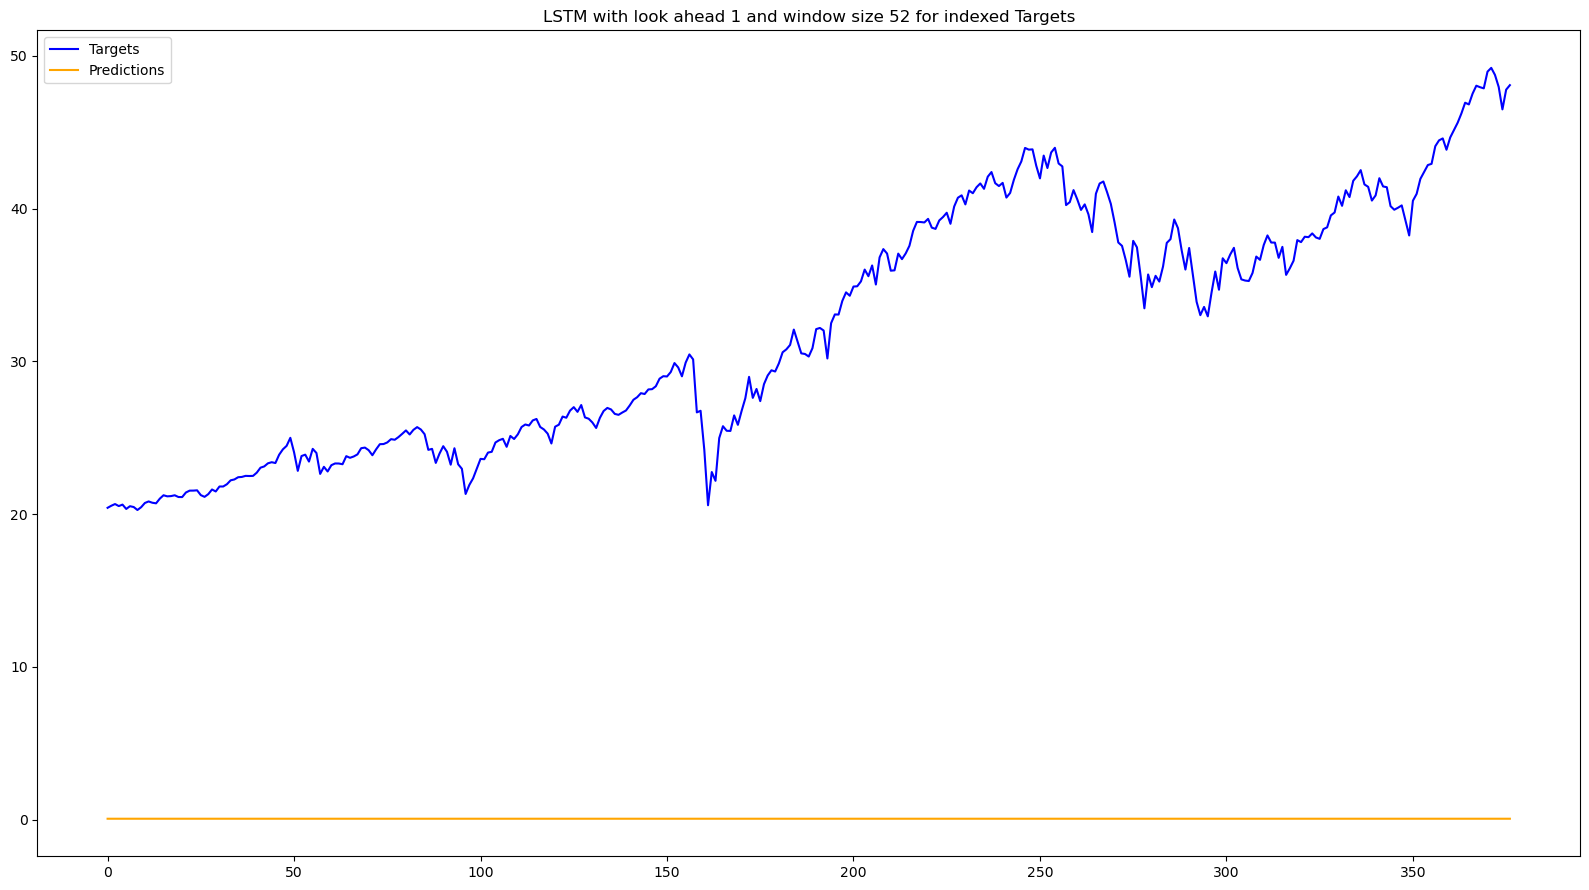

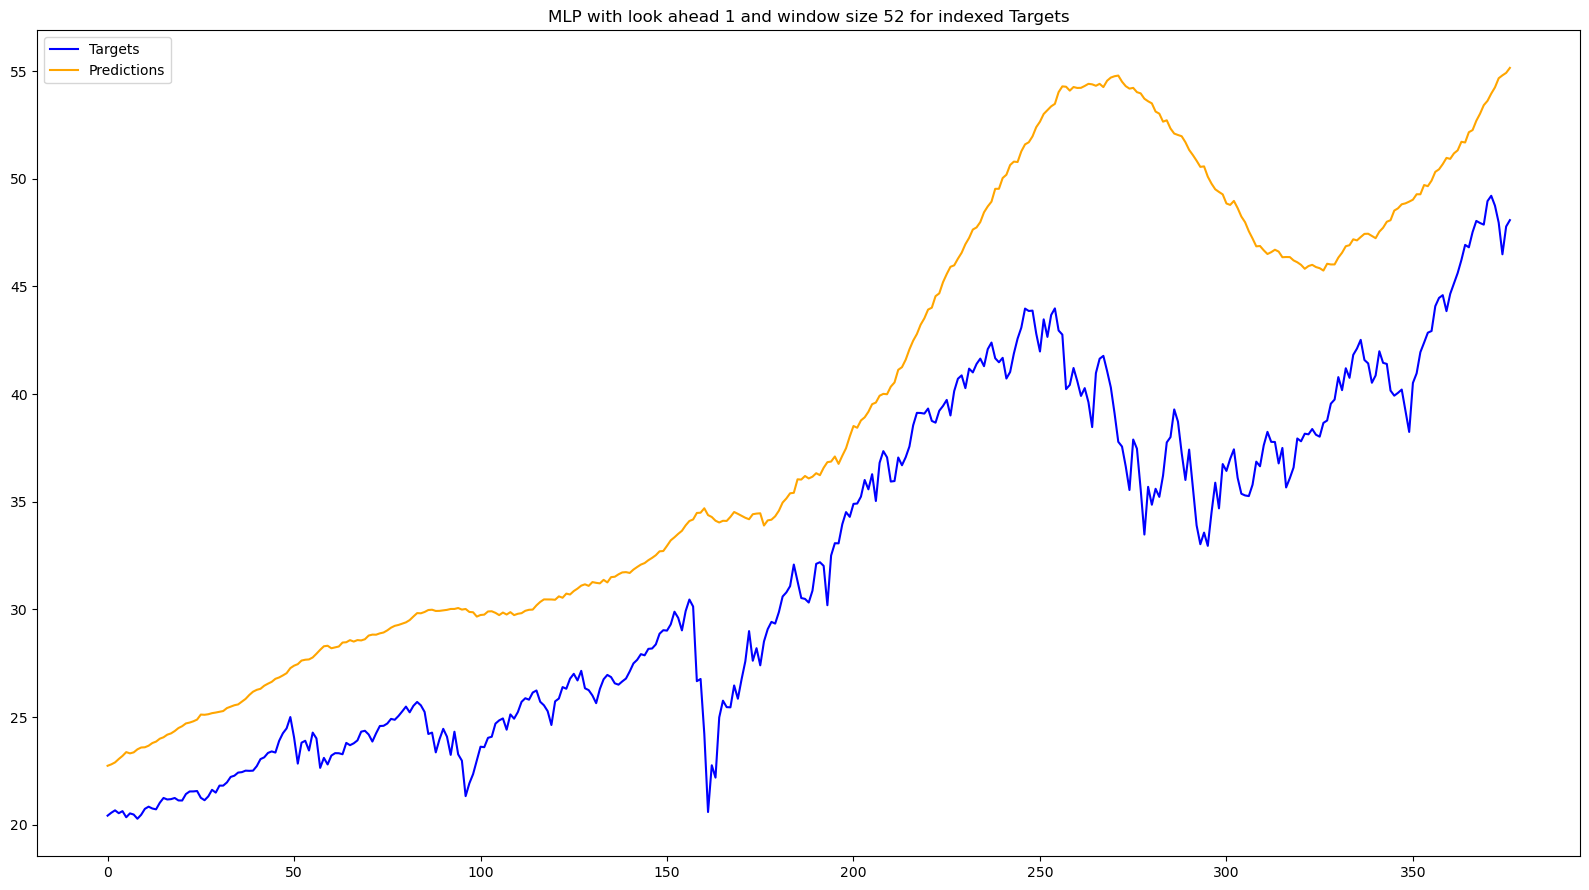

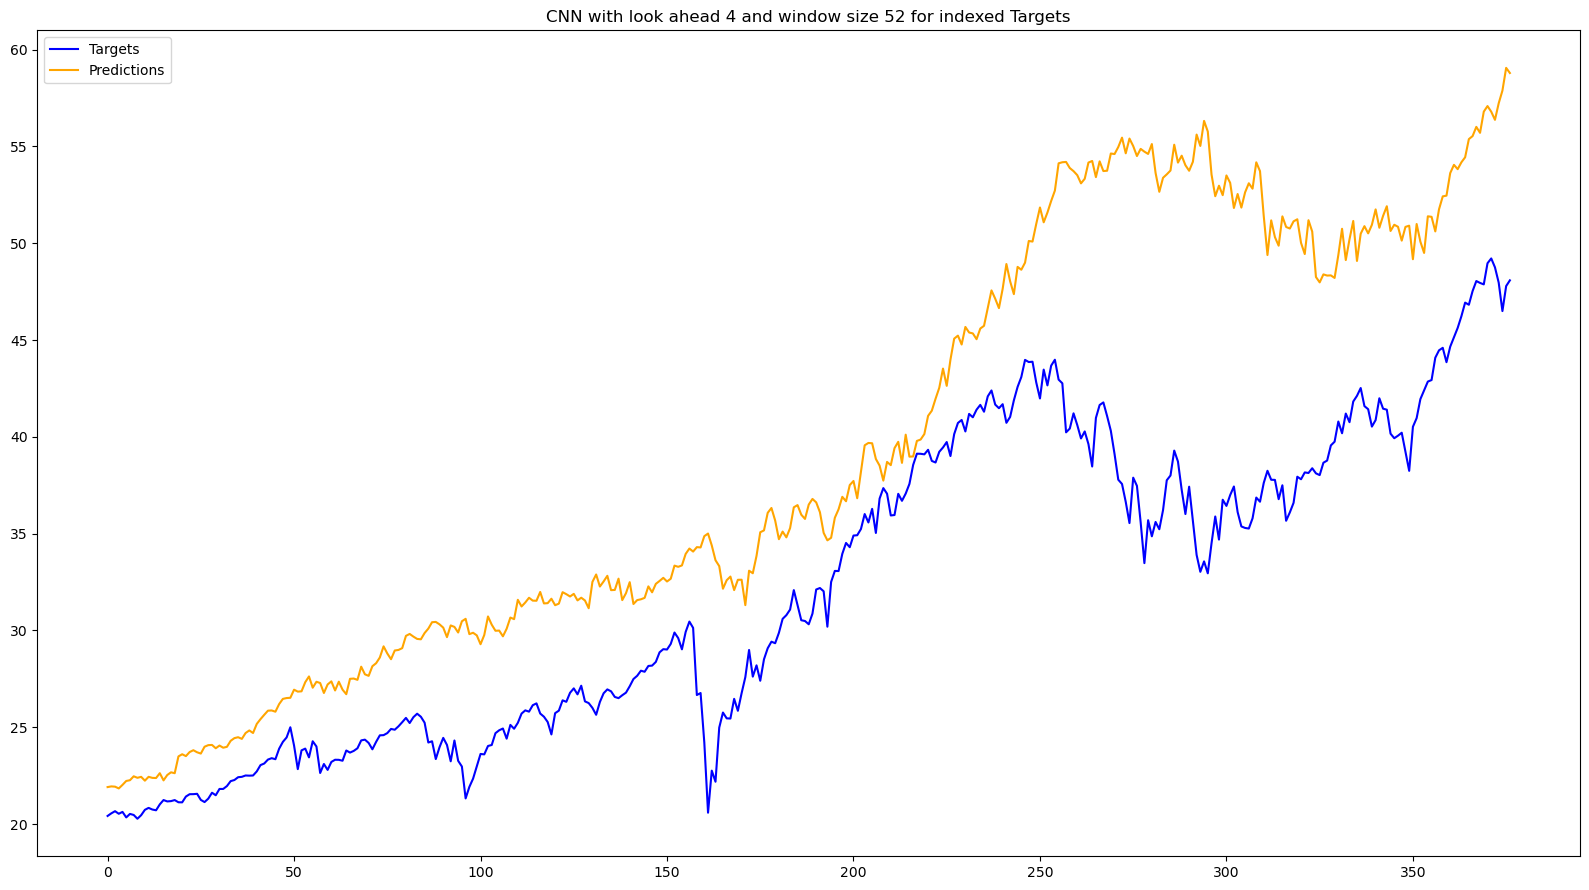

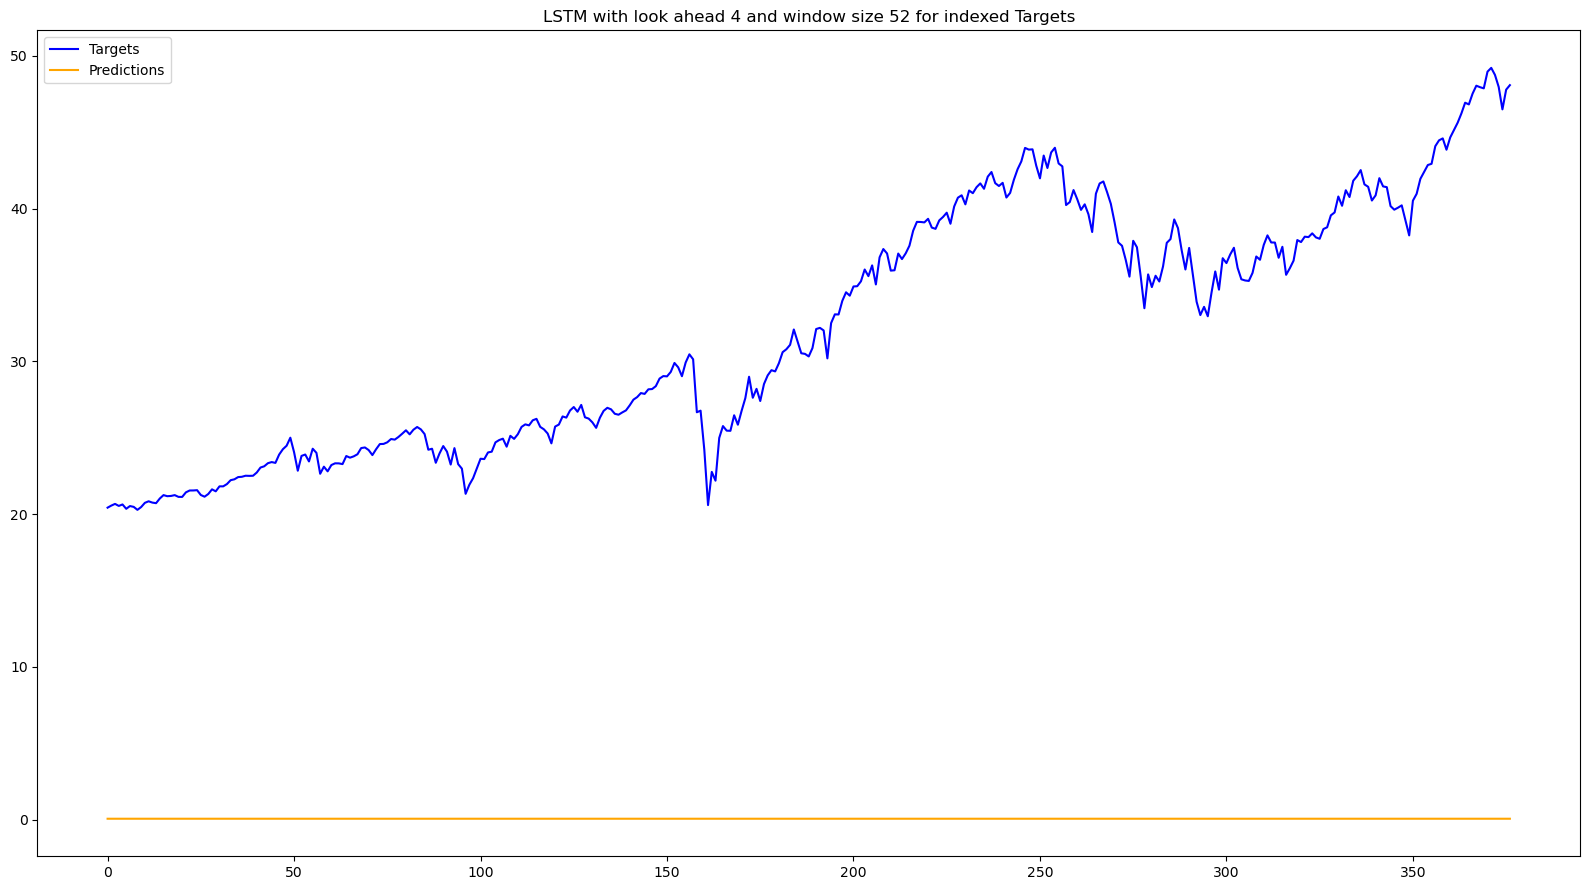

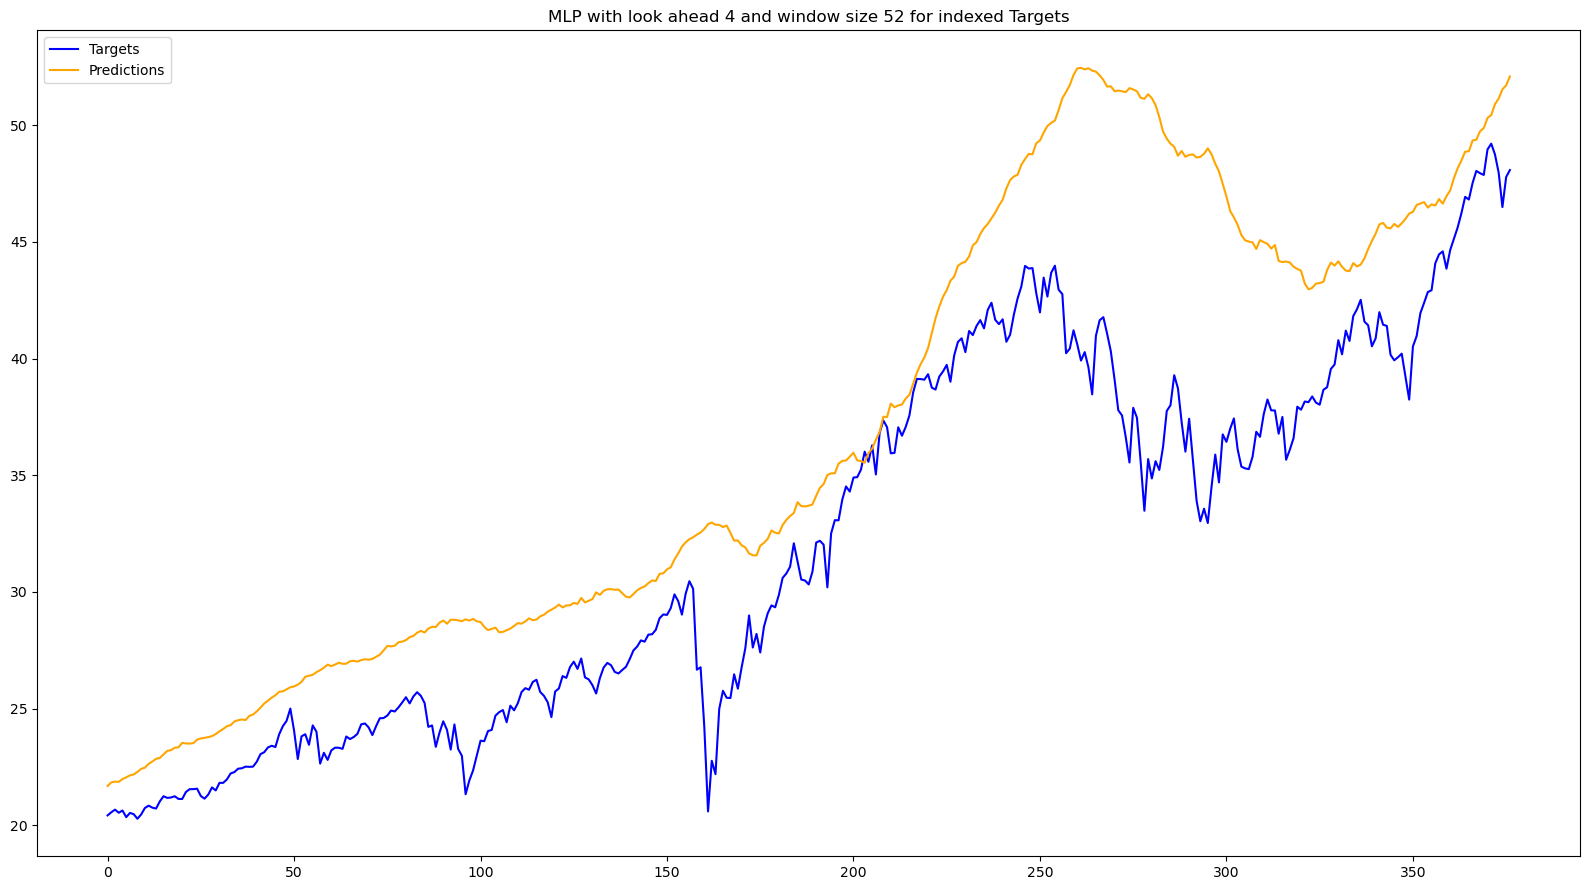

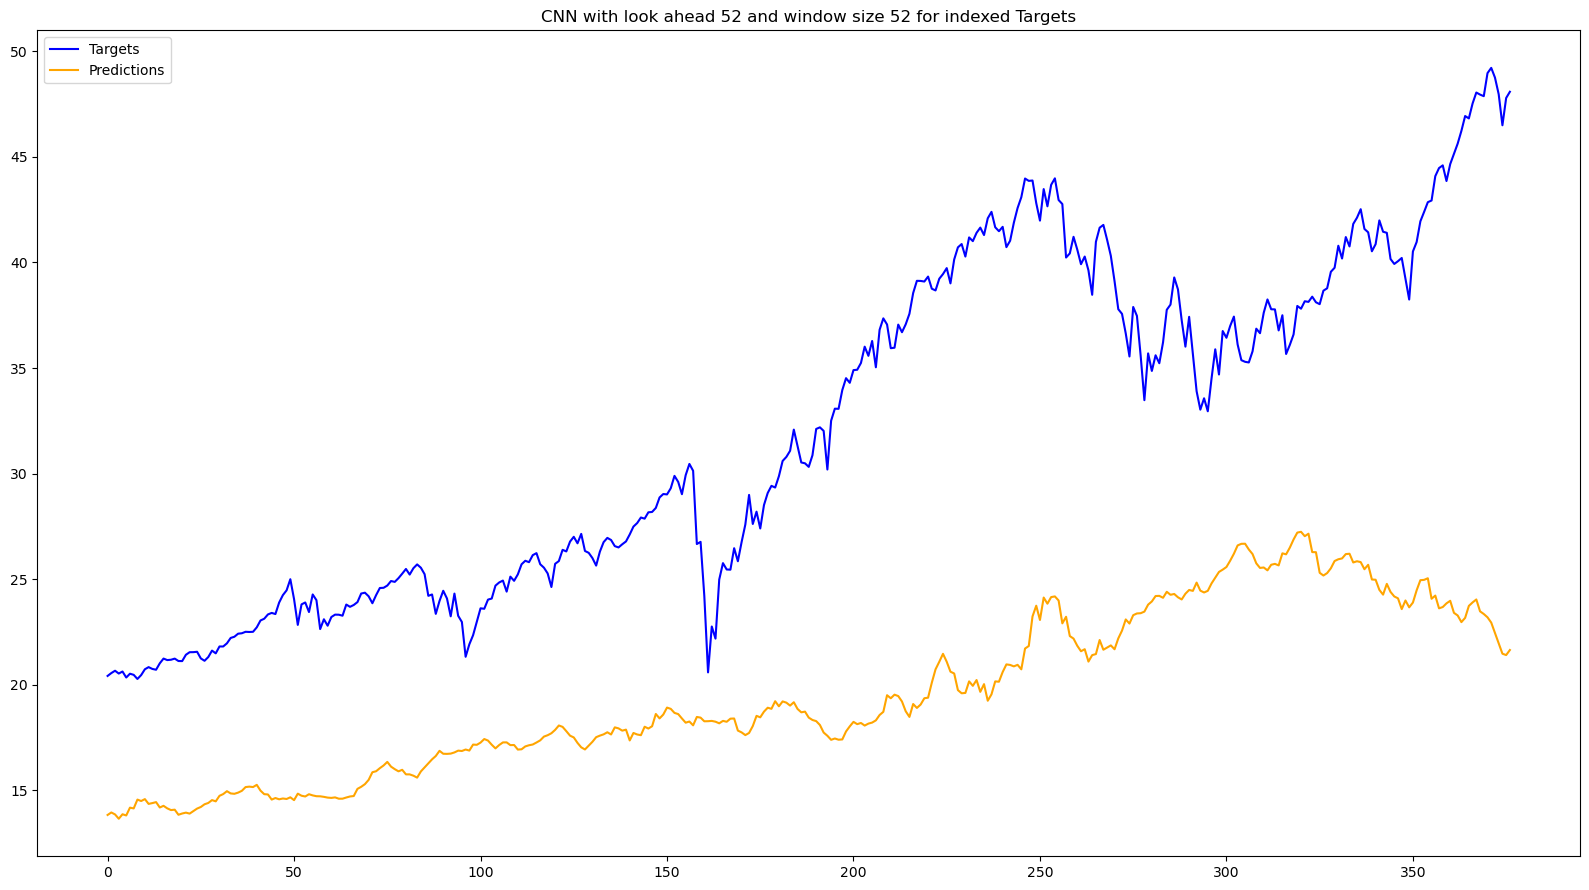

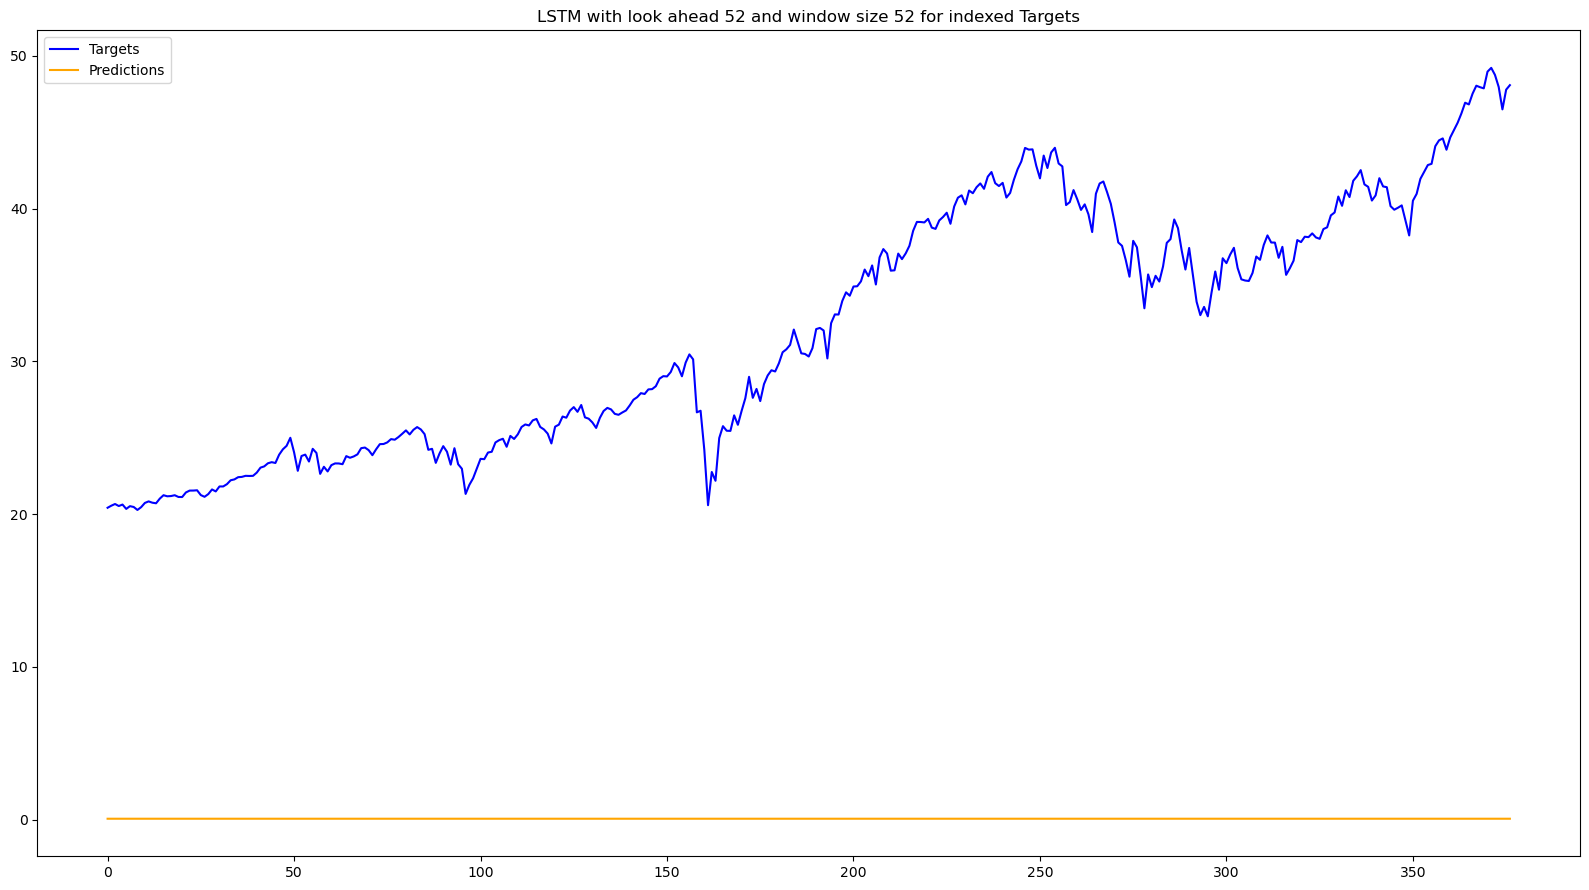

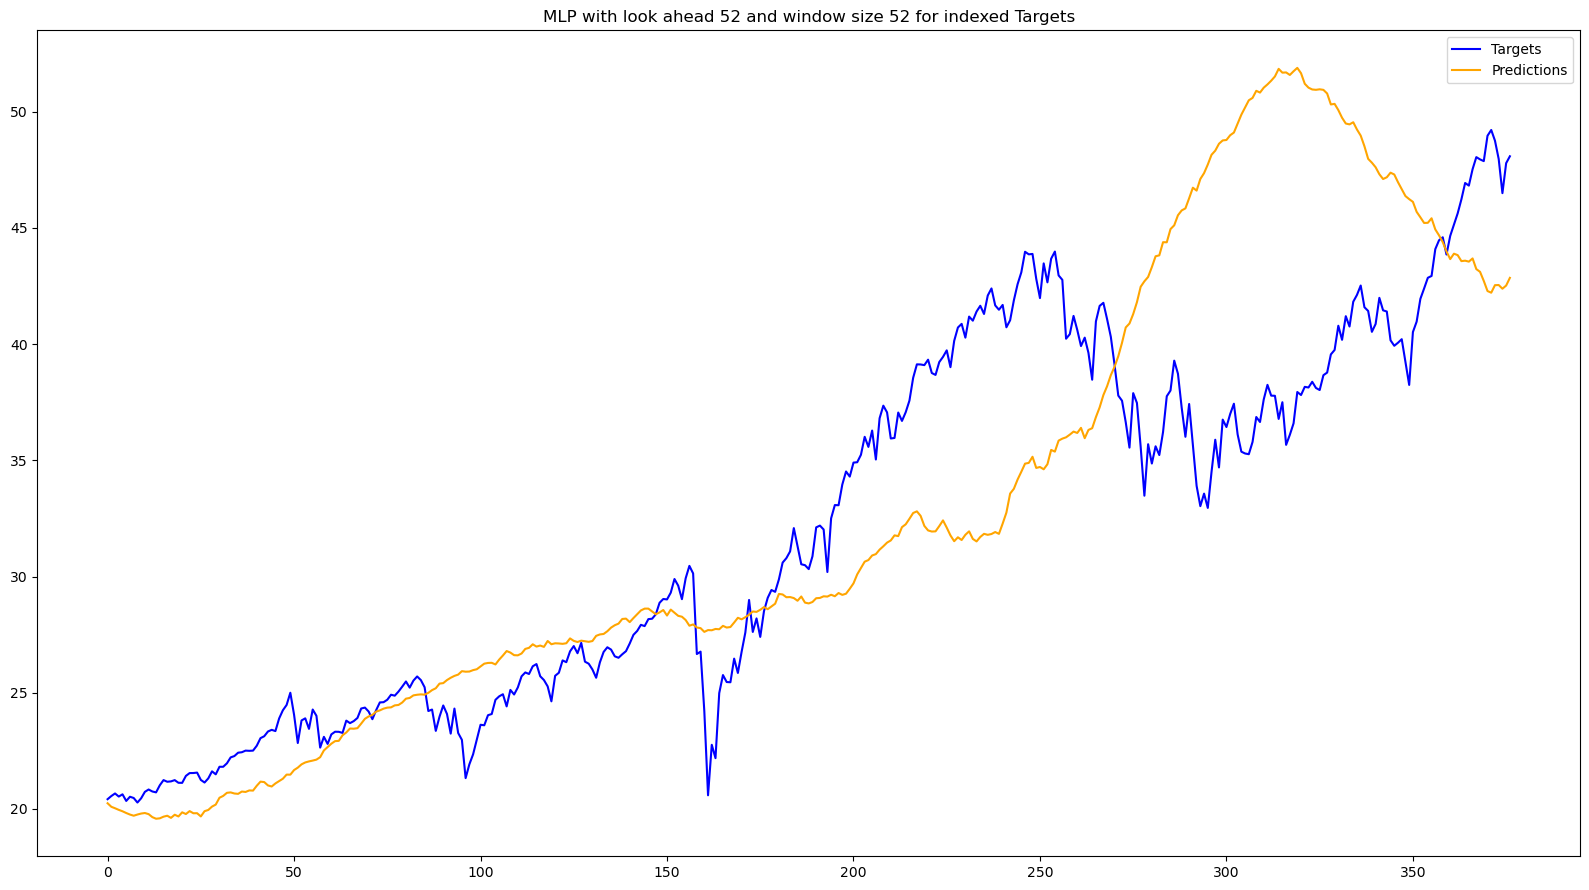

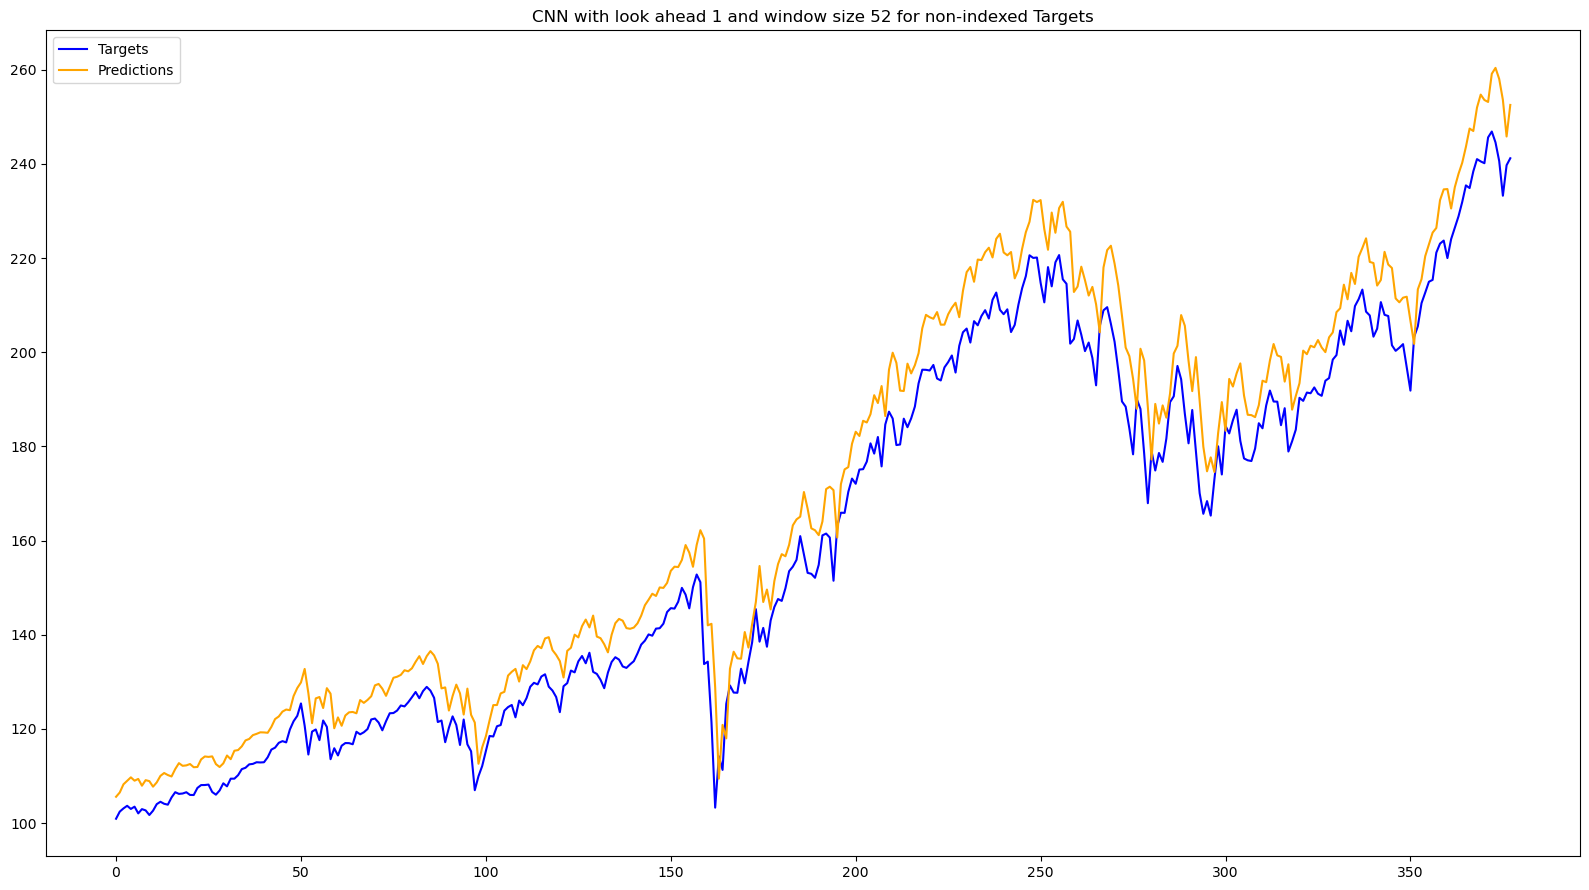

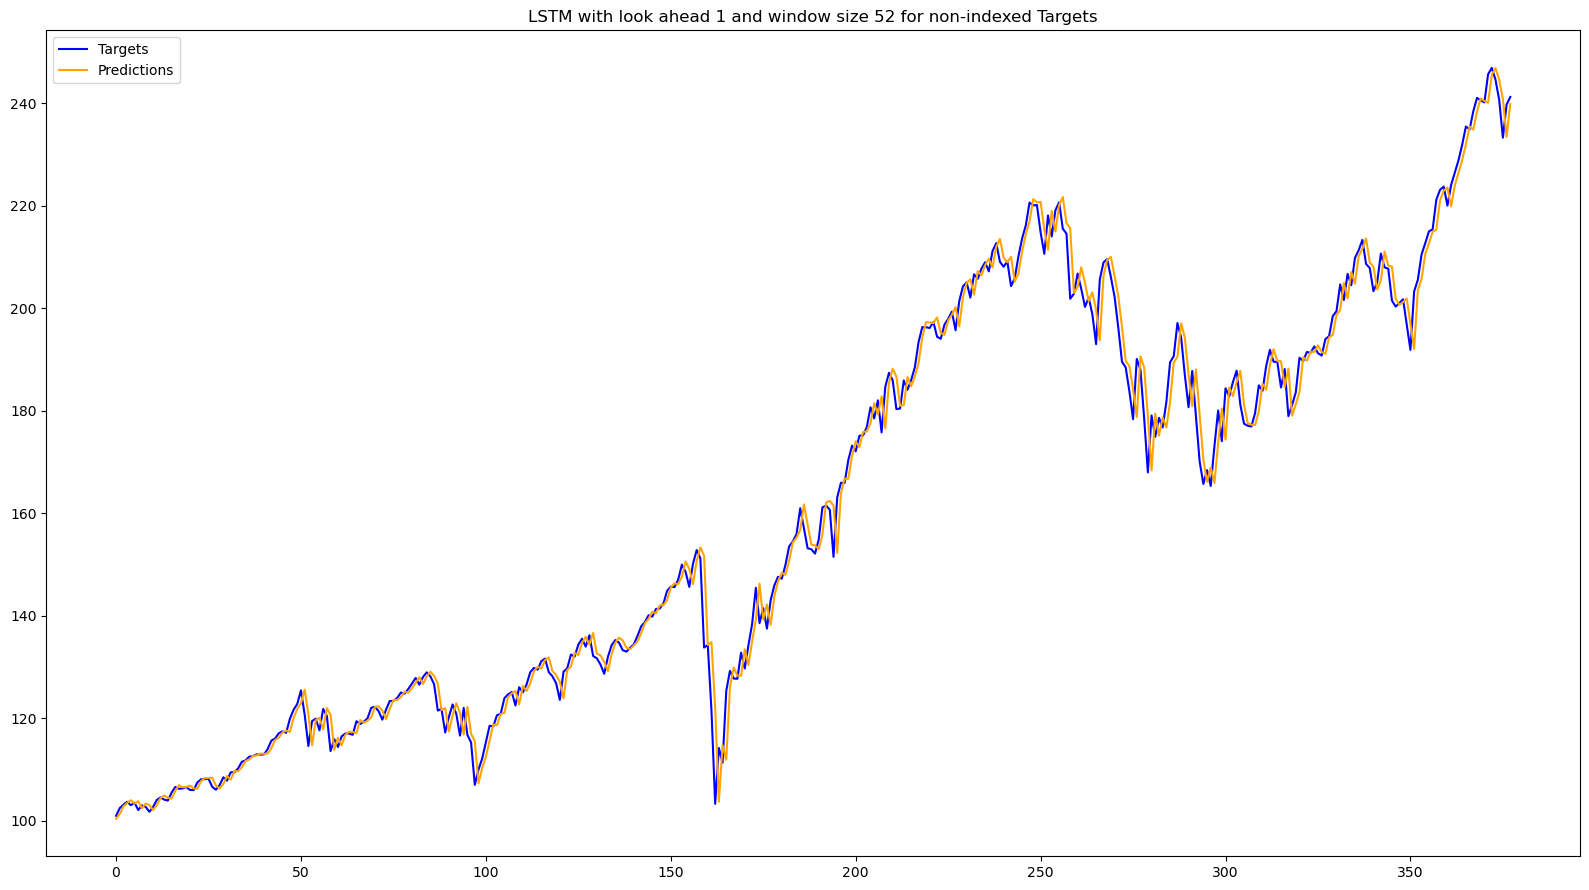

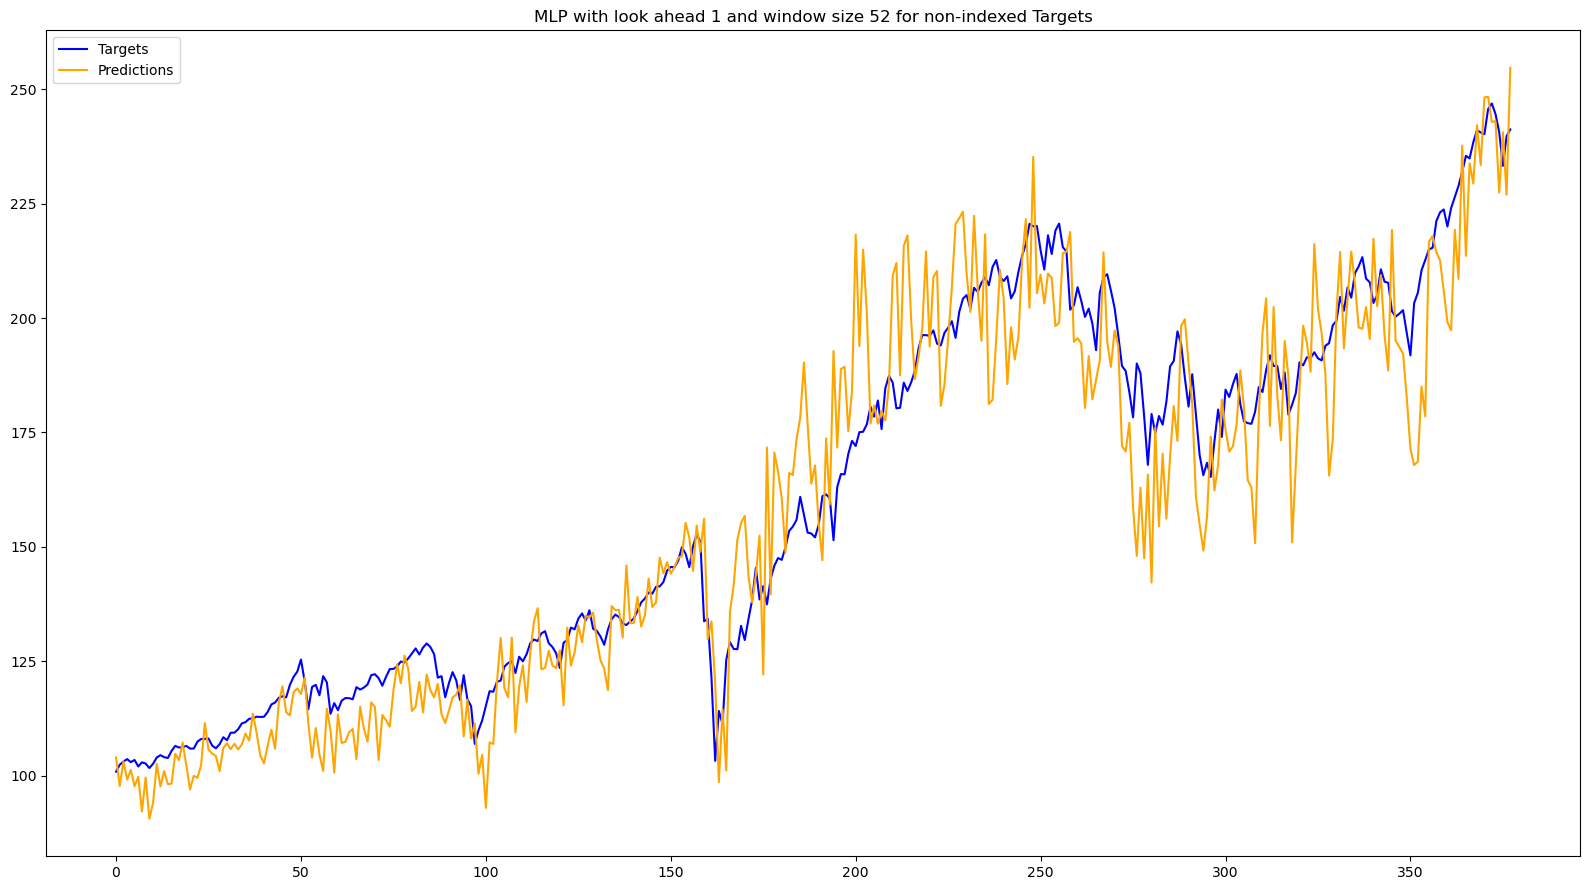

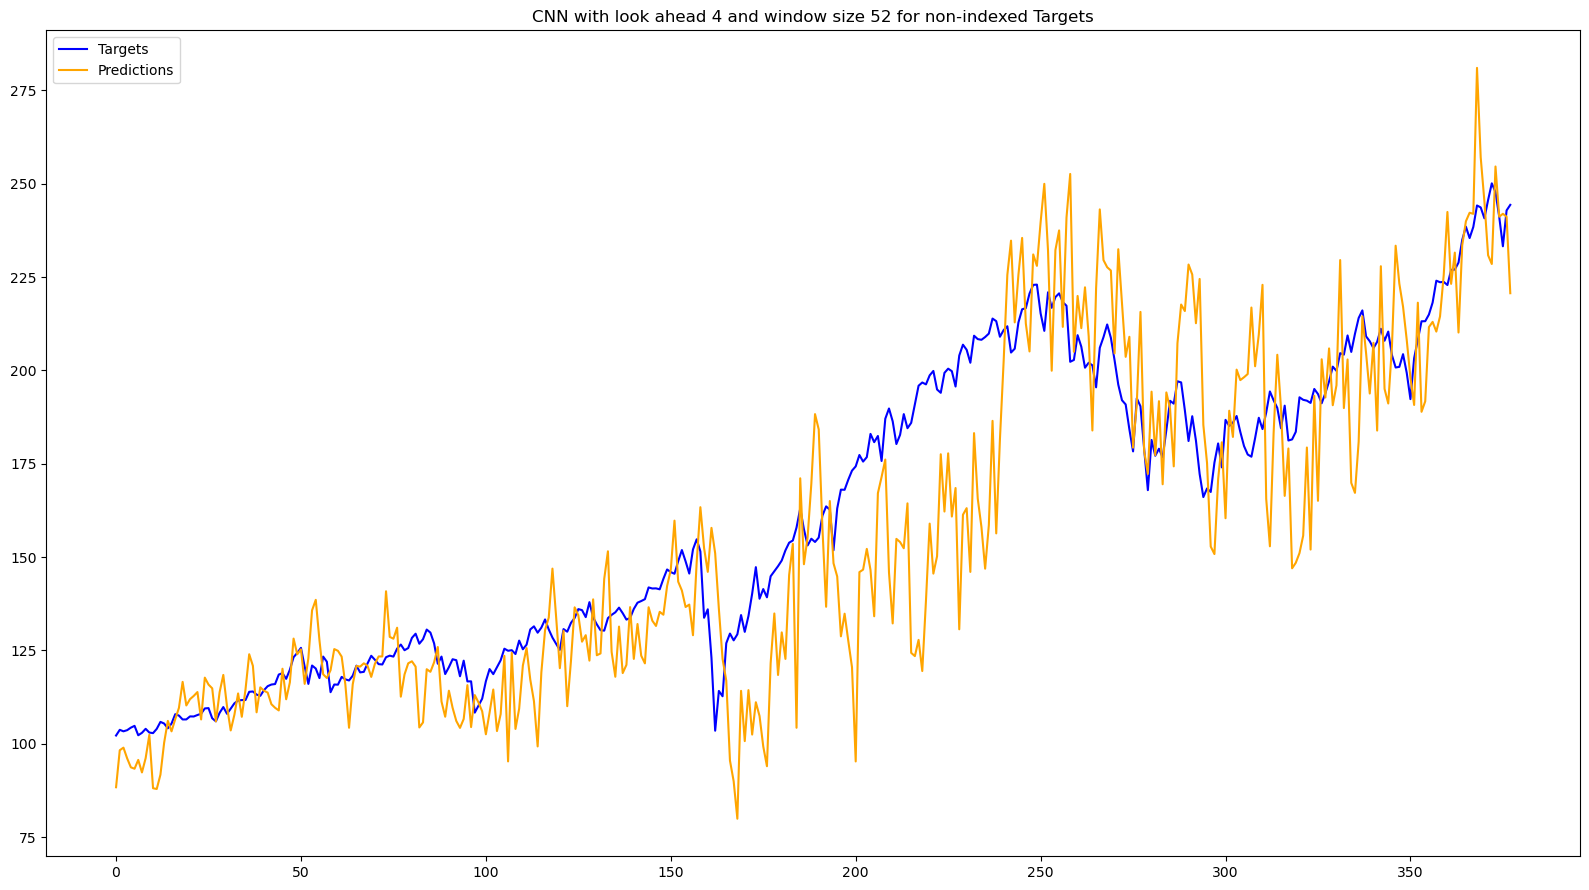

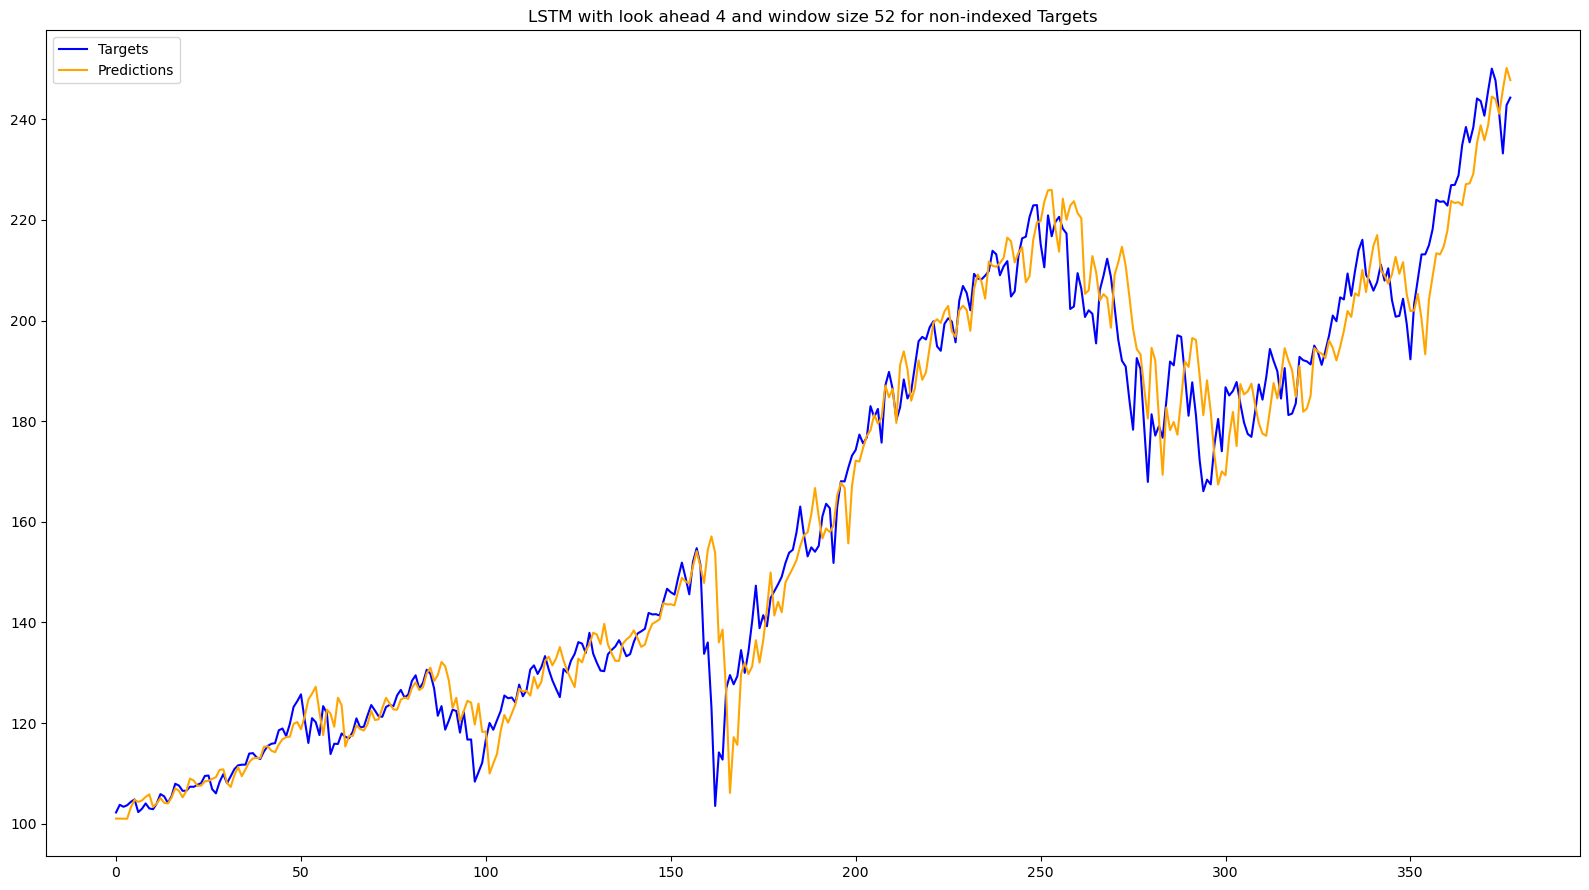

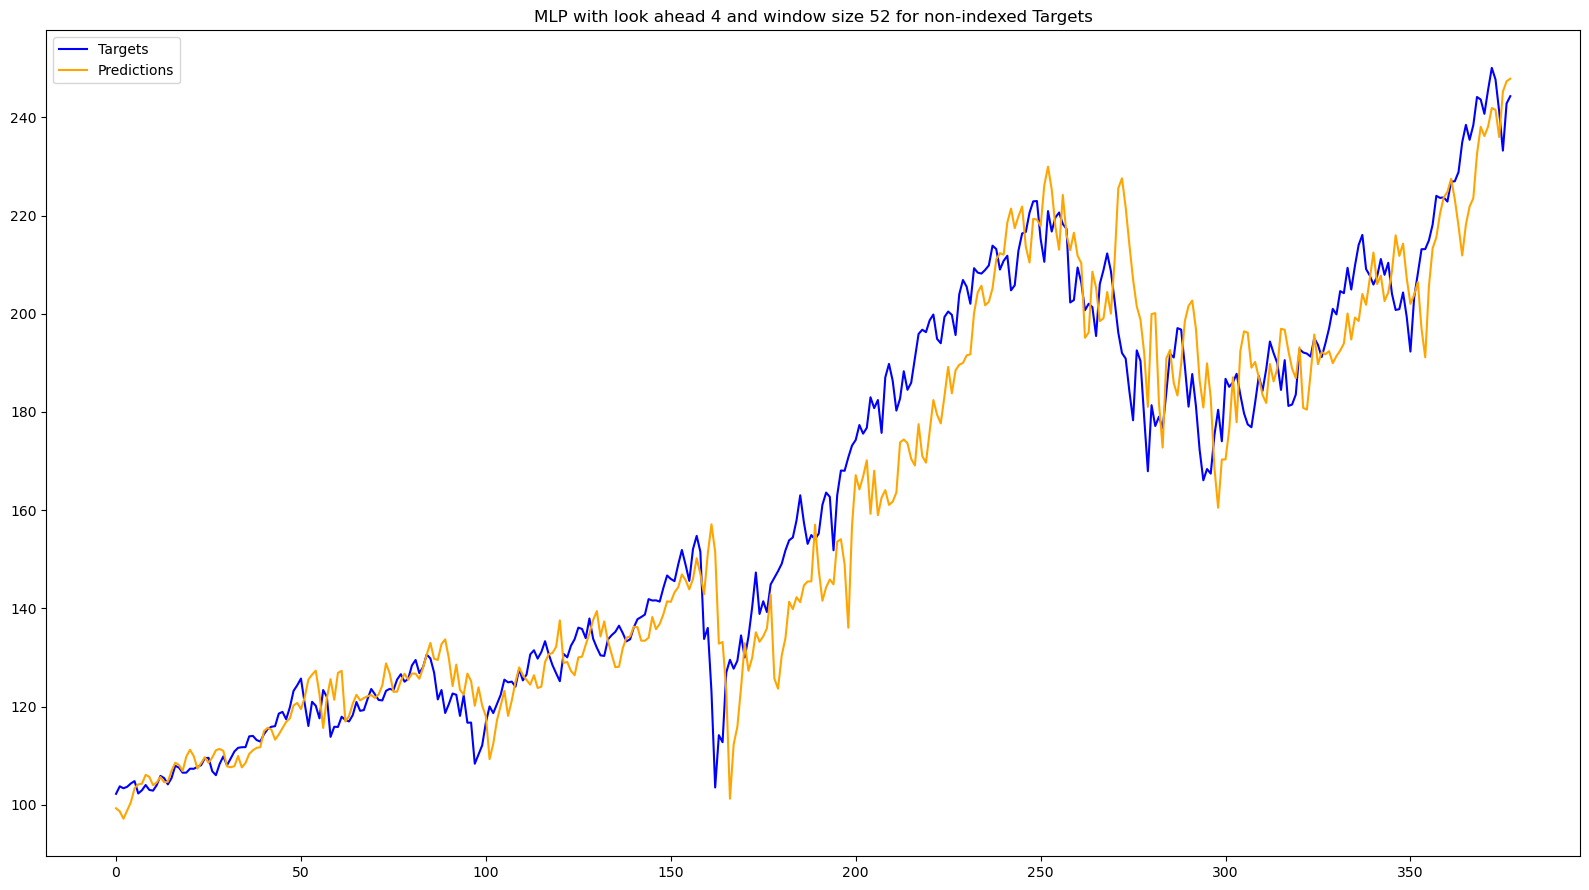

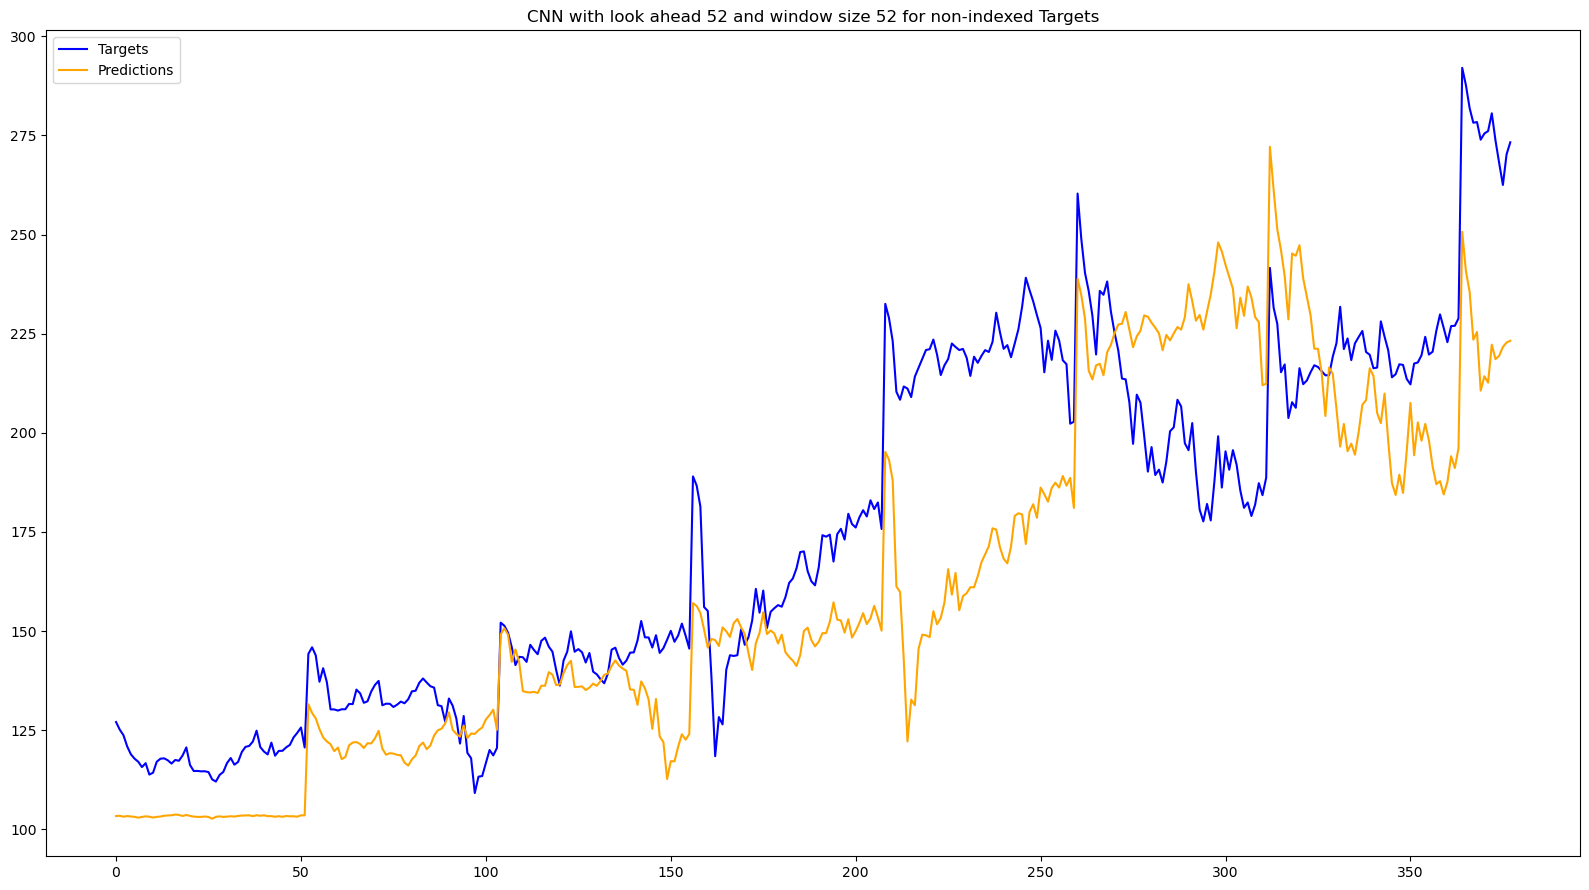

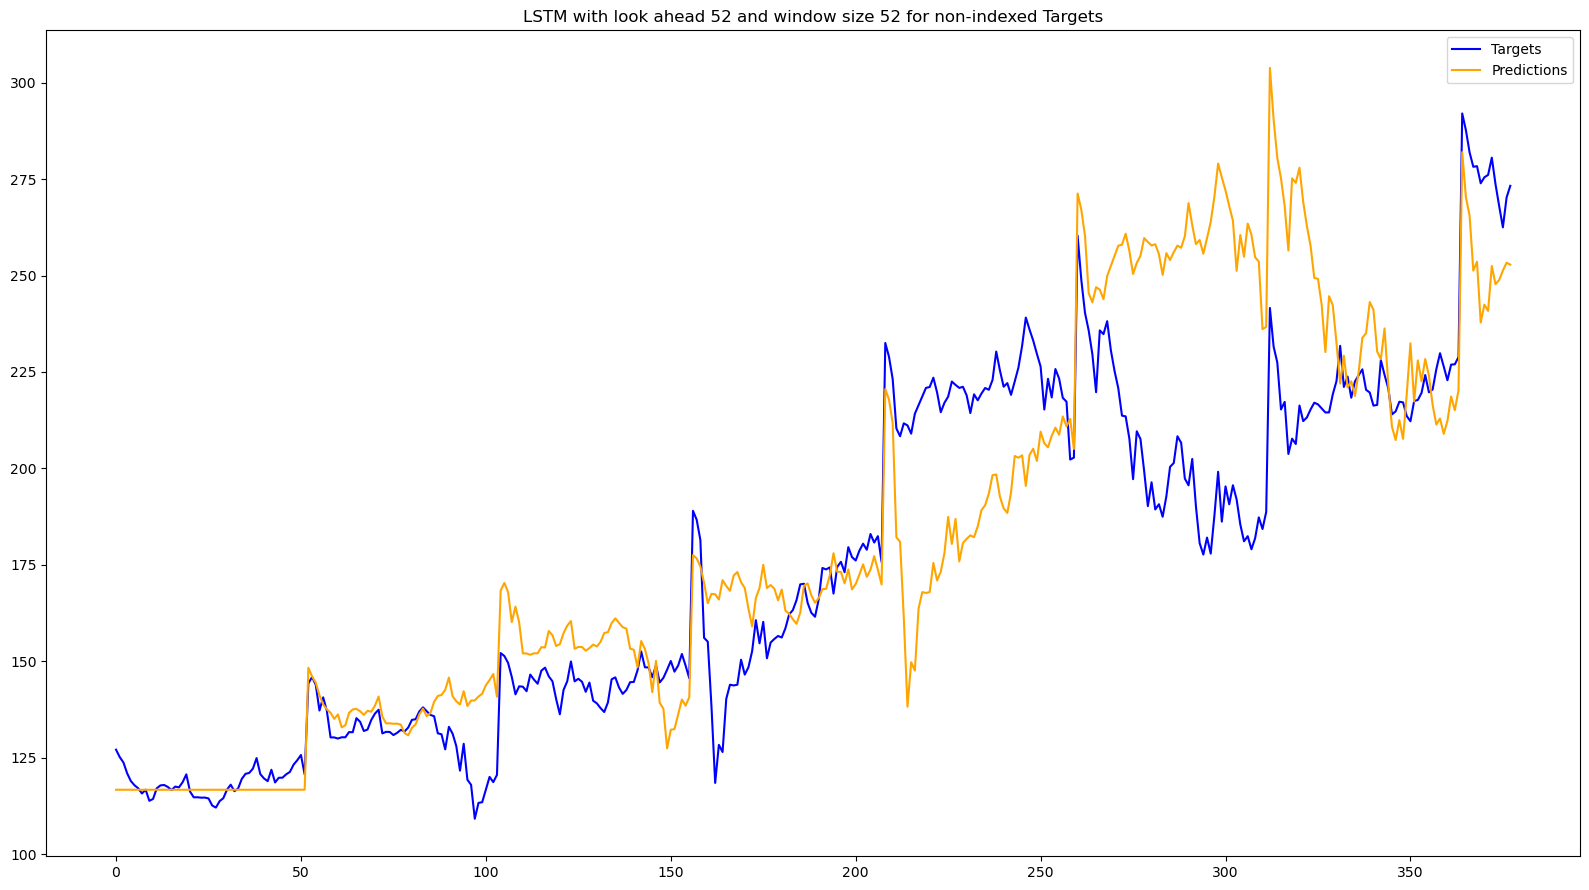

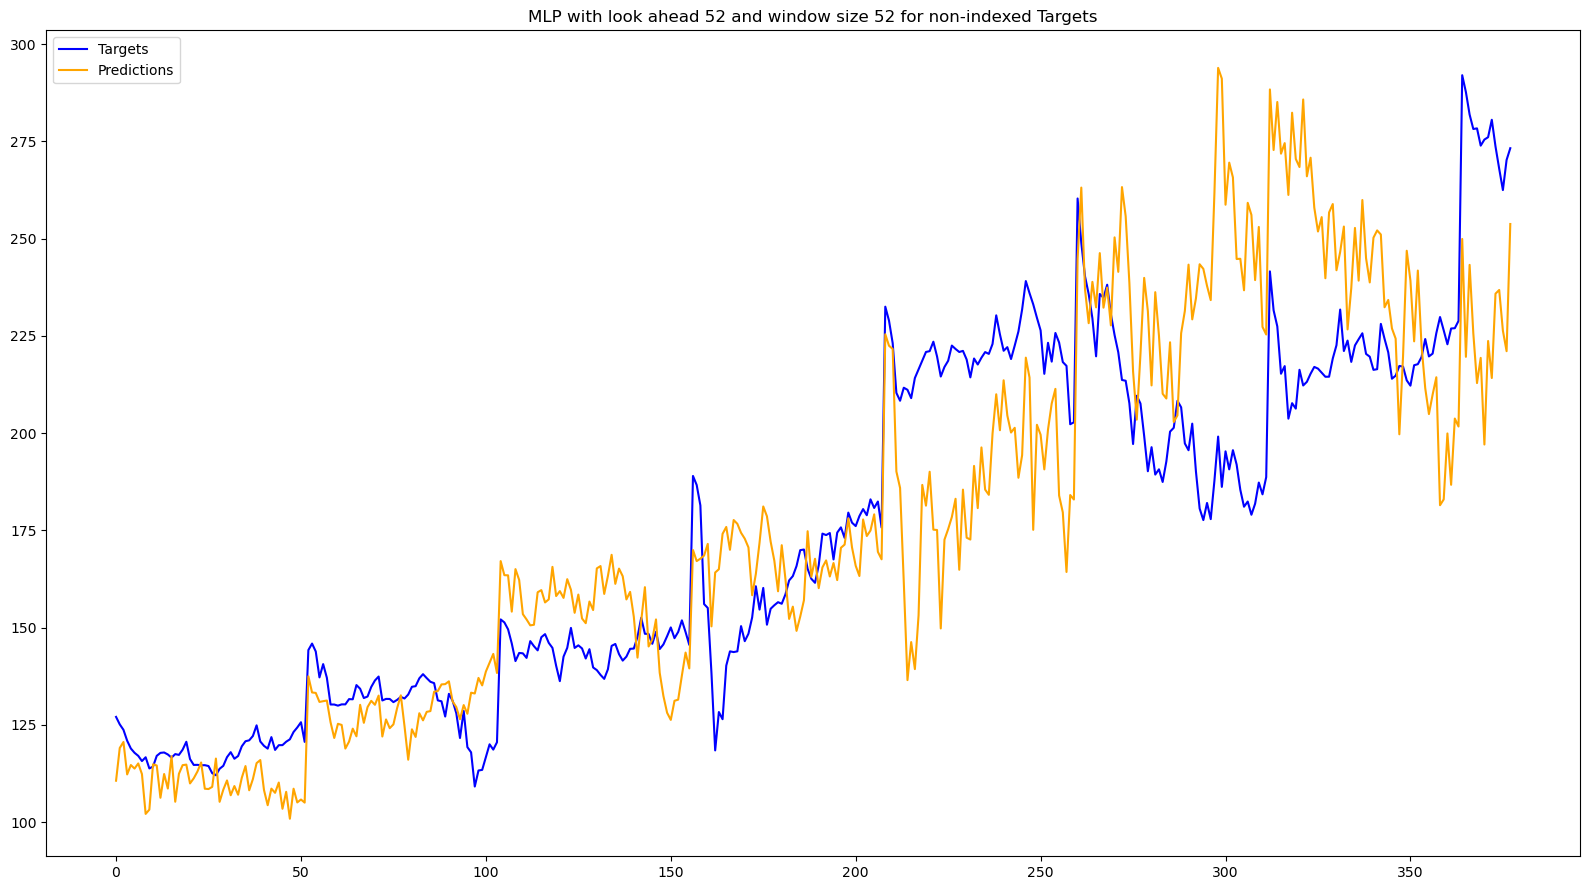

In [10]:
for result in results:
    indexed = result[0]
    look_ahead = result[1]
    name = result[2]
    preds = result[-2]
    targets = result[-1]

    if indexed:
        title = f"{name} with look ahead {look_ahead} and window size {window_size} for indexed Targets"
        plot_prediction_indexed(preds, targets, title)
    else:
        title = f"{name} with look ahead {look_ahead} and window size {window_size} for non-indexed Targets"
        plot_prediction_returns(preds, targets, title, look_ahead)

